In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("reubensuju/celeb-df-v2")

print("Path to dataset files:", path)

In [ ]:
!rm -rf /content/sample_data

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d reubensuju/celeb-df-v2

Dataset URL: https://www.kaggle.com/datasets/reubensuju/celeb-df-v2
License(s): unknown
^C


In [ ]:
!pip install -q transformers datasets accelerate opencv-python timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import random
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
from tqdm import tqdm

In [ ]:
# --- Step 1: Configuration ---
REAL_DIR = "/kaggle/input/celeb-df-v2/Celeb-real"
FAKE_DIR = "/kaggle/input/celeb-df-v2/Celeb-synthesis"
SAVE_DIR = "/content/frames"

frames_dir_real = os.path.join(SAVE_DIR, "real")
frames_dir_fake = os.path.join(SAVE_DIR, "fake")

os.makedirs(SAVE_DIR, exist_ok=True)

NUM_VIDEOS = 200
MAX_FRAMES_PER_VIDEO = 5
EXTRACT_FPS = 1  # 1 frame per second

random.seed(42)

In [ ]:
real_videos = [f for f in os.listdir(REAL_DIR) if f.endswith(".mp4")]
fake_videos = [f for f in os.listdir(FAKE_DIR) if f.endswith(".mp4")]

print(f"Total real videos   : {len(real_videos)}")
print(f"Total fake videos   : {len(fake_videos)}")

Total real videos   : 590
Total fake videos   : 5639


In [ ]:
real_frames = [f for f in os.listdir(frames_dir_real) if f.endswith(".jpg")]
fake_frames = [f for f in os.listdir(frames_dir_fake) if f.endswith(".jpg")]

print(f"Total real images   : {len(real_frames)}")
print(f"Total fake images   : {len(fake_frames)}")

Total real images   : 1000
Total fake images   : 1000


In [ ]:
# Cleanup
import shutil

if os.path.exists(SAVE_DIR):
    shutil.rmtree(SAVE_DIR)
os.makedirs(os.path.join(SAVE_DIR, "real"), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "fake"), exist_ok=True)

print("Cleanup complete")

Cleanup complete


In [ ]:
# --- Step 2: Sample NUM_VIDEOS from each class ---
real_videos = random.sample([f for f in os.listdir(REAL_DIR) if f.endswith(".mp4")], NUM_VIDEOS)
fake_videos = random.sample([f for f in os.listdir(FAKE_DIR) if f.endswith(".mp4")], NUM_VIDEOS)

In [ ]:
# --- Step 3: Extract frames ---
def extract_frames(video_path, save_dir, label):
    os.makedirs(save_dir, exist_ok=True)
    video_id = os.path.splitext(os.path.basename(video_path))[0]
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / EXTRACT_FPS) if fps > 0 else 1

    count, saved = 0, 0
    while cap.isOpened() and saved < MAX_FRAMES_PER_VIDEO:
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            fname = f"{label}_{video_id}_frame{saved}.jpg"
            fpath = os.path.join(save_dir, fname)
            cv2.imwrite(fpath, frame)
            saved += 1
        count += 1
    cap.release()

# Extract real frames
for vid in tqdm(real_videos, desc="Extracting real frames"):
    extract_frames(os.path.join(REAL_DIR, vid), os.path.join(SAVE_DIR, "real"), "real")

# Extract fake frames
for vid in tqdm(fake_videos, desc="Extracting fake frames"):
    extract_frames(os.path.join(FAKE_DIR, vid), os.path.join(SAVE_DIR, "fake"), "fake")


Extracting fake frames: 100%|██████████| 200/200 [00:23<00:00,  8.67it/s]


In [ ]:
# --- Step 4: Prepare dataset ---
def build_image_list(folder, label):
    return [(os.path.join(folder, fname), label)
            for fname in os.listdir(folder) if fname.endswith(".jpg")]

real_images = build_image_list(os.path.join(SAVE_DIR, "real"), 0)
fake_images = build_image_list(os.path.join(SAVE_DIR, "fake"), 1)

all_data = real_images + fake_images
train_data, val_data = train_test_split(all_data, test_size=0.2, stratify=[lbl for _, lbl in all_data], random_state=42)

In [ ]:
# --- Step 5: Dataset Class ---
class FrameDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert("RGB")
        image = self.transform(image)
        return {"pixel_values": image, "label": label}

In [ ]:
# --- Step 6: Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = FrameDataset(train_data, transform)
val_dataset = FrameDataset(val_data, transform)

# --- Step 7: Load ViT and Feature Extractor ---
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)

# --- Step 8: Metrics ---
def compute_metrics(pred):
    preds = torch.argmax(torch.tensor(pred.predictions), dim=1)
    labels = torch.tensor(pred.label_ids)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- Step 9: TrainingArguments ---
training_args = TrainingArguments(
    output_dir="./vit-deepfake-celebdf",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    remove_unused_columns=False
)

# --- Step 10: Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# --- Step 11: Train! ---
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.537900,0.500359,0.825000,0.825871
2,0.296000,0.382365,0.830000,0.841121
3,0.260400,0.256220,0.872500,0.872180
4,0.213100,0.346174,0.835000,0.823529
5,0.176700,0.405435,0.840000,0.820225
6,0.186600,0.233234,0.902500,0.902256
7,0.142100,0.233487,0.890000,0.884211
8,0.123900,0.199200,0.925000,0.925373
9,0.174200,0.241705,0.912500,0.911839
10,0.079800,0.184618,0.920000,0.920000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.537900,0.500359,0.825000,0.825871
2,0.296000,0.382365,0.830000,0.841121
3,0.260400,0.256220,0.872500,0.872180
4,0.213100,0.346174,0.835000,0.823529
5,0.176700,0.405435,0.840000,0.820225
6,0.186600,0.233234,0.902500,0.902256
7,0.142100,0.233487,0.890000,0.884211
8,0.123900,0.199200,0.925000,0.925373
9,0.174200,0.241705,0.912500,0.911839
10,0.079800,0.184618,0.920000,0.920000


TrainOutput(global_step=5000, training_loss=0.028411834825202823, metrics={'train_runtime': 8830.0389, 'train_samples_per_second': 18.12, 'train_steps_per_second': 0.566, 'total_flos': 1.239871833833472e+19, 'train_loss': 0.028411834825202823, 'epoch': 100.0})

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from torchvision import transforms
from transformers import ViTForImageClassification

# --- Load test video list ---
test_video_list_path = "/kaggle/input/celeb-df-v2/List_of_testing_videos.txt"
with open(test_video_list_path, 'r') as f:
    lines = f.readlines()

test_videos = [(line.strip().split()[1], int(line.strip().split()[0])) for line in lines]

# --- Setup frame extraction ---
TEST_VIDEO_BASE = "/kaggle/input/celeb-df-v2"
TEST_FRAMES_DIR = "/content/test_frames"
os.makedirs(TEST_FRAMES_DIR, exist_ok=True)

In [ ]:
def extract_test_frames(video_rel_path, label, fps=1, max_frames=5):
    video_path = os.path.join(TEST_VIDEO_BASE, video_rel_path)
    video_id = os.path.basename(video_rel_path).replace(".mp4", "")
    save_path = os.path.join(TEST_FRAMES_DIR, f"{label}_{video_id}")
    os.makedirs(save_path, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    interval = int(frame_rate / fps) if frame_rate > 0 else 1

    count = 0
    saved = 0
    while cap.isOpened() and saved < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if count % interval == 0:
            frame_file = os.path.join(save_path, f"frame_{saved}.jpg")
            cv2.imwrite(frame_file, frame)
            saved += 1
        count += 1
    cap.release()
    return [(os.path.join(save_path, f), label) for f in os.listdir(save_path) if f.endswith(".jpg")]

# --- Extract test frames ---
all_test_images = []
for video_path, label in tqdm(test_videos, desc="Extracting test frames"):
    all_test_images.extend(extract_test_frames(video_path, label))

# --- Image preprocessing ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Extracting test frames: 100%|██████████| 518/518 [01:15<00:00,  6.84it/s]


Running inference: 100%|██████████| 2586/2586 [00:54<00:00, 47.24it/s]



 Accuracy: 0.3055
 F1 Score: 0.2123

 Confusion Matrix:
[[TP: 242, FN: 648],
 [FP: 1148, TN: 548]]

 Classification Report:

              precision    recall  f1-score   support

        Real       0.46      0.32      0.38      1696
        Fake       0.17      0.27      0.21       890

    accuracy                           0.31      2586
   macro avg       0.32      0.30      0.30      2586
weighted avg       0.36      0.31      0.32      2586



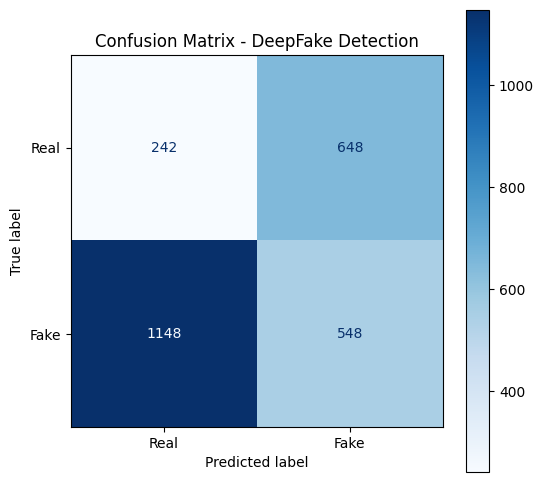

In [103]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    ConfusionMatrixDisplay, accuracy_score, f1_score
)
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch

# --- Load fine-tuned model ---
model_path = "/content/vit-deepfake-celebdf/checkpoint-5000"
model = ViTForImageClassification.from_pretrained(model_path)
model.eval().cuda()

# --- Inference ---
y_true, y_pred = [], []
with torch.no_grad():
    for img_path, label in tqdm(all_test_images, desc="Running inference"):
        image = Image.open(img_path).convert("RGB")
        tensor = transform(image).unsqueeze(0).cuda()
        output = model(pixel_values=tensor).logits
        pred = torch.argmax(output, dim=1).item()
        y_true.append(label)
        y_pred.append(pred)

# --- Evaluate ---
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"\n Accuracy: {acc:.4f}")
print(f" F1 Score: {f1:.4f}")

# --- Compute confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # [Real=1, Fake=0]

TP = cm[0][0]  # Real correctly predicted as Real
FN = cm[0][1]  # Real predicted as Fake
FP = cm[1][0]  # Fake predicted as Real
TN = cm[1][1]  # Fake correctly predicted as Fake

print("\n Confusion Matrix:")
print(f"[[TP: {TP}, FN: {FN}],\n [FP: {FP}, TN: {TN}]]")

# --- Classification report ---
target_names = ["Real", "Fake"]
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# --- Plot confusion matrix ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - DeepFake Detection")
plt.show()

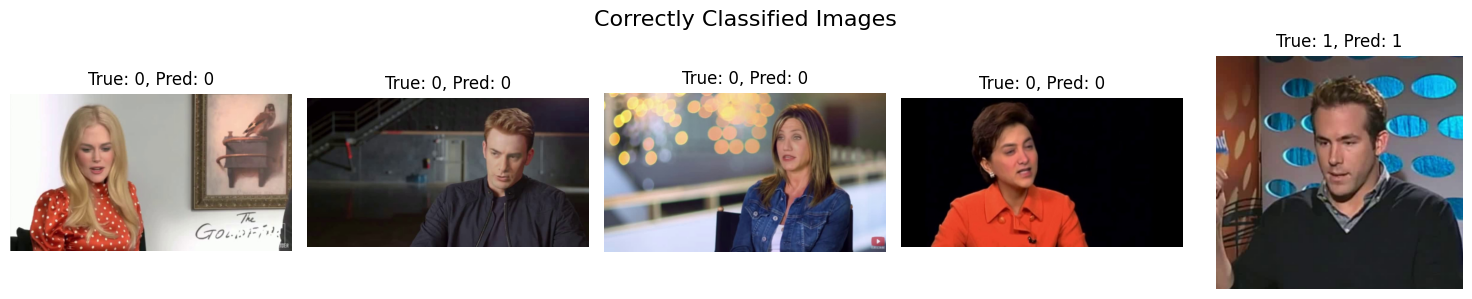

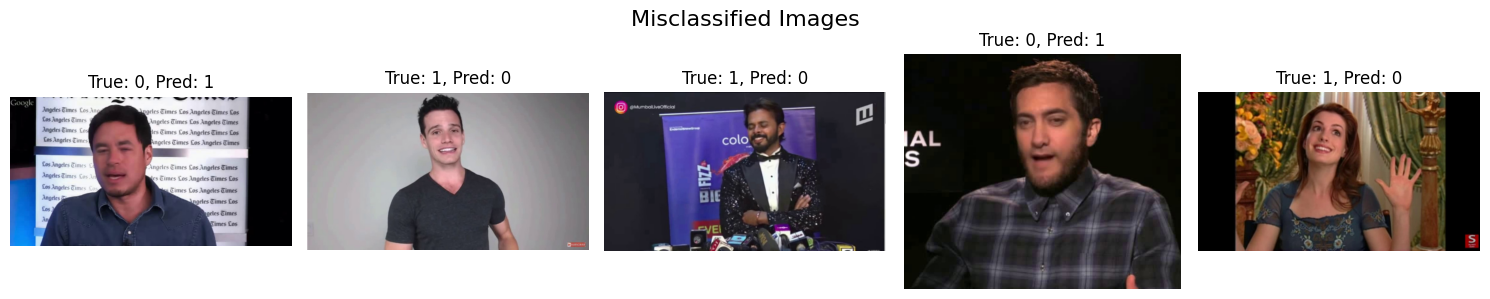

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_examples(examples, title, rows=1):
    cols = len(examples)
    fig, axs = plt.subplots(rows, cols, figsize=(3*cols, 3))
    fig.suptitle(title, fontsize=16)

    if cols == 1:
        axs = [axs]

    for ax, example in zip(axs, examples):
        img = mpimg.imread(example['frame_path'])
        ax.imshow(img)
        ax.set_title(f"True: {example['true_label']}, Pred: {example['predicted_label']}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# --- Plot 5 correctly and 5 incorrectly classified images ---
plot_examples(correct_sample, "Correctly Classified Images")
plot_examples(misclassified_sample, "Misclassified Images")


In [ ]:
import pandas as pd

# Step: Build results dataframe
results = []
for (img_path, label), pred in zip(all_test_images, y_pred):
    video_id = os.path.basename(os.path.dirname(img_path))  # like: "0_id3_id2_0001"
    results.append({
        "video_id": video_id,
        "frame_path": img_path,
        "true_label": label,
        "predicted_label": pred
    })

# Step: Save to CSV
results_df = pd.DataFrame(results)
csv_path = "/content/deepfake_test_results.csv"
results_df.to_csv(csv_path, index=False)

print(f"Results saved to: {csv_path}")

Results saved to: /content/deepfake_test_results.csv


In [101]:
import shutil

# Zip the folder
# shutil.make_archive('/content/frames', 'zip', '/content/frames')
shutil.make_archive('/content/logs', 'zip', '/content/logs')
shutil.make_archive('/content/wandb', 'zip', '/content/wandb')

'/content/wandb.zip'

In [100]:
import os

filepath = '/content/frames'; size_bytes = os.path.getsize(filepath)
size_gb = size_bytes / (1024 ** 3)
print(f'{filepath}: {size_gb:.2f} GB')

/content/frames: 0.00 GB


In [104]:
from huggingface_hub import notebook_login
notebook_login()


In [105]:
from huggingface_hub import create_repo, upload_folder

repo_name = "vit-deepfake-detector-celebdfv2"
org_or_user = "ashwin-raikar"
repo_id = f"{org_or_user}/{repo_name}"

# Optional: add model card
with open("./vit-deepfake-celebdf/checkpoint-5000/README.md", "w") as f:
    f.write(
        "# ViT DeepFake Detector\n"
        "- Architecture: `google/vit-base-patch16-224-in21k`\n"
        "- Fine-tuned on: Celeb-DF v2\n"
        "- Task: Binary classification (Real vs Fake)\n"
        "- Accuracy & F1: [Add your scores here]\n"
    )

In [106]:
upload_folder(
    repo_id=repo_id,
    folder_path="./vit-deepfake-celebdf/checkpoint-5000",
    commit_message="Initial model upload: ViT fine-tuned on Celeb-DF v2",
    ignore_patterns=["logs", "*.zip", "*.csv"]
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9561: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/687M [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ashwin-raikar/vit-deepfake-detector-celebdfv2/commit/ac3bdad8fdffa0eb839009a2790e19c74f2ebcd8', commit_message='Initial model upload: ViT fine-tuned on Celeb-DF v2', commit_description='', oid='ac3bdad8fdffa0eb839009a2790e19c74f2ebcd8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ashwin-raikar/vit-deepfake-detector-celebdfv2', endpoint='https://huggingface.co', repo_type='model', repo_id='ashwin-raikar/vit-deepfake-detector-celebdfv2'), pr_revision=None, pr_num=None)